#Importing the libraries

In [0]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import spacy
import tensorflow_hub as hub
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import pickle
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, Dropout
from keras.utils.np_utils import to_categorical
EN = spacy.load('en_core_web_sm')

Using TensorFlow backend.


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
cd drive/My\ Drive/search engine

/content/drive/My Drive/search engine


# Loading the data

In [0]:
Preprocessed_data = pd.read_pickle('Preprocessed_data_mini.pkl')
print(Preprocessed_data.shape)
Preprocessed_data.head()

(154251, 11)


,original_title,post_corpus,question_content,question_url,tags,overall_scores,answers_content,sentiment_polarity,sentiment_subjectivity,processed_title,overall_scores_norm
0,Get a preview JPEG of a PDF on Windows?,get preview jpeg pdf windows cross platform py...,get preview jpeg pdf windows cross platform py...,https://stackoverflow.com/questions/502,python|windows|image|pdf,11,You can use ImageMagick's convert utility for ...,0.100000,0.400000,get preview jpeg pdf windows,0.002665
1,How can I get the authenticated user name unde...,get authenticated user name apache using plain...,get authenticated user name apache using plain...,https://stackoverflow.com/questions/1417,php|apache|authentication|http-authentication,37,I think that you are after this,0.000000,0.000000,get authenticated user name apache using plain...,0.010932
4,TestDriven.NET is not running my SetUp methods...,testdriven net running setup methods mbunit cr...,testdriven net running setup methods mbunit cr...,https://stackoverflow.com/questions/3984,.net|visual-studio|tdd|mbunit|testdriven.net,2,After having this problem for weeks on Vista 6...,0.100000,0.200000,testdriven net running setup methods mbunit,-0.000197
6,Does running a SQL Server 2005 database in com...,running sql server 2005 database compatibility...,running sql server 2005 database compatibility...,https://stackoverflow.com/questions/7237,sql-server|database,6,"I think i read somewhere, that the SQL Server ...",0.101389,0.298611,running sql server 2005 database compatibility...,0.001075
7,How do I generate WPF controls through code,generate wpf controls code trying get head aro...,generate wpf controls code trying get head aro...,https://stackoverflow.com/questions/7586,c#|.net|wpf|xaml,7,The cell location is an attached property - th...,0.159133,0.415320,generate wpf controls code,0.001393


# visaulizing the tags using the word cloud

In [0]:
# Make a dict having tag frequencies
Preprocessed_data.tags = Preprocessed_data.tags.apply(lambda x: x.split('|'))# Making the list of tags
tag_freq_dict = {}
for tags in Preprocessed_data.tags:
    for tag in tags:
        if tag not in tag_freq_dict:
            tag_freq_dict[tag] = 0
        else:
            tag_freq_dict[tag] += 1

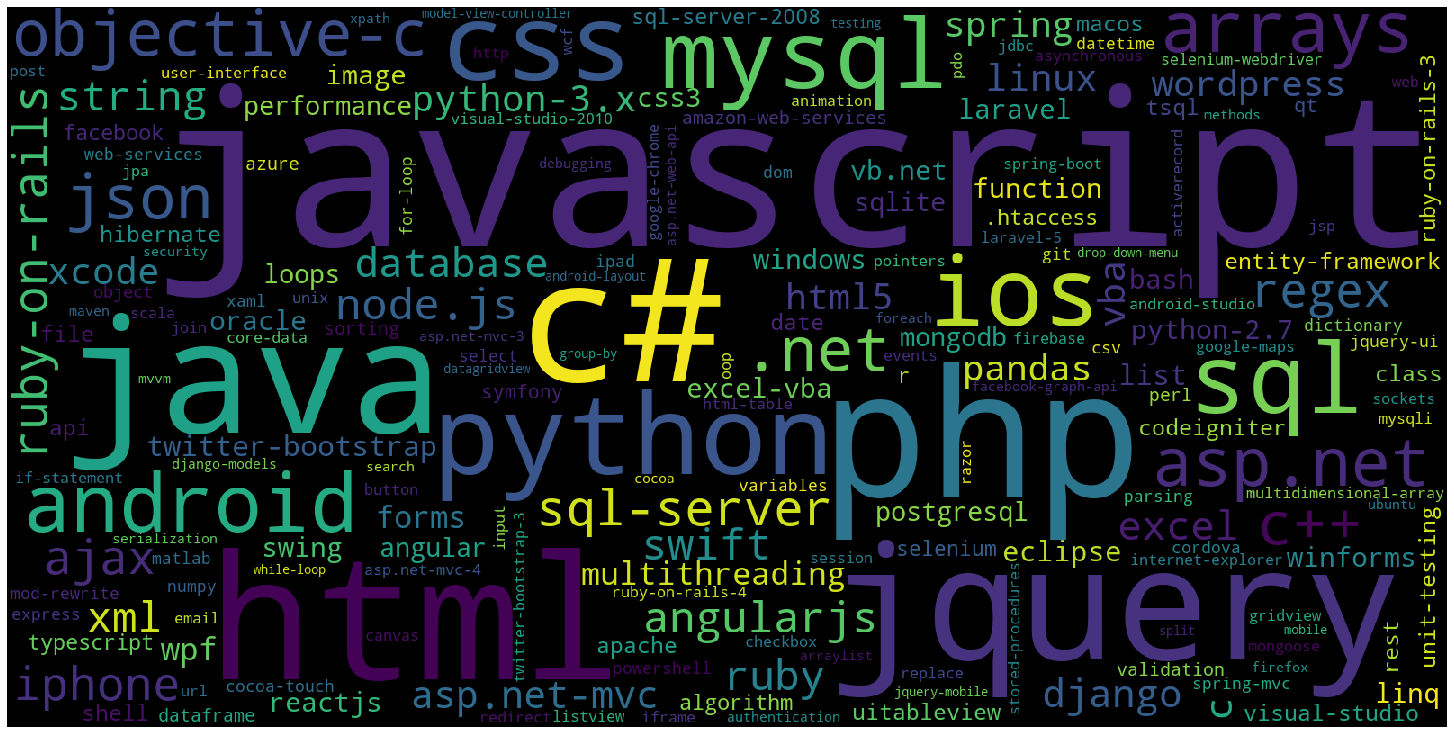

In [0]:
# Visualize all tags based on their frequencies using a WordCloud
wordcloud = WordCloud(background_color='black',
                      width=1600,
                      height=800,
                    ).generate_from_frequencies(tag_freq_dict)

fig = plt.figure(figsize=(20,20))
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

- Although I did filter out a lot of tags in Data processing step, there still exists a lot of "stray" tags which may appear only once or twice as compared to thousands of occurences for other tags. This increases the dimensions of the ground truth data, which is not desirable for our model. Thus we extract the top 500 tags based on their occurences.

In [0]:
# Get most common tags
tags_to_use = 500
tag_freq_dict_sorted = dict(sorted(tag_freq_dict.items(), key=lambda x: x[1], reverse=True))
final_tags = list(tag_freq_dict_sorted.keys())[:tags_to_use]
len(final_tags)

500

In [0]:
# Change tag data to only for final_tags
final_tag_data = []
for tags in Preprocessed_data.tags:
    temp = []
    for tag in tags:
        if tag in final_tags:
            temp.append(tag)
    final_tag_data.append(temp)

In [0]:
# final_tag_data.to_pickle('final_tag_data.pkl')
with open('data/final_tag_data.pickle', 'wb') as handle:
    pickle.dump(final_tag_data, handle, protocol=pickle.HIGHEST_PROTOCOL)


In [0]:
with open('data/final_tag_data.pickle', 'rb') as handle:
    final_tag_data = pickle.load(handle)

- Since we are dealing with multi label data, i.e. there are more than one answers for each input, I decided to use the MultiLabelBinarizer from sklearn


In [0]:
from sklearn.preprocessing import MultiLabelBinarizer
tag_encoder = MultiLabelBinarizer()
tags_encoded = tag_encoder.fit_transform(final_tag_data)
# tags_encoded = tag_encoder.fit_transform(Preprocessed_data.tags)
tags_encoded.shape

(154251, 500)

- In order for our model to understand the raw text data, we need to vectorize it. Bag of Words and TF-IDF are very common approaches for vectorizing. However, since I would be using an artificial neural network as my model, the sparse nature of BOW and TFIDF would pose a problem. Thus I decided to go for Word Embeddings, which are dense vector representations and thus perfect for our neural network.


- The way talk on StackOverflow is very technical and they use a very specific vocabulary of words, it is not a good idea to use pre-trained WordEmbedding (although google has a lot of good ones) because they are trained on plain English text such a Shakespeare and would not be able to understand the relations between the words in our vocabulary. Thus I decided to train a WordEmbeddings model of my own from scratch.

In [0]:
# Word2Vec
import gensim

# WORD2VEC 
W2V_SIZE = 300
W2V_WINDOW = 7
W2V_EPOCH = 32
W2V_MIN_COUNT = 10

# Collect corpus for training word embeddings
documents = [_text.split() for _text in np.array(Preprocessed_data.post_corpus)]  # I used the entire corpus for training, because it contains the entire conversation of related to a user's posts

In [0]:
# Train Word Embeddings and save
'''
w2v_model = gensim.models.word2vec.Word2Vec(size=W2V_SIZE, 
                                            window=W2V_WINDOW, 
                                            min_count=W2V_MIN_COUNT, 
                                            workers=8)
w2v_model.build_vocab(documents)
words = w2v_model.wv.vocab.keys()
vocab_size = len(words)
print("Vocab size", vocab_size)
# Train Word Embeddings
w2v_model.train(documents, total_examples=len(documents), epochs=W2V_EPOCH)
w2v_model.save('models/SO_word2vec_embeddings.bin')
print("END embedding created")
'''

Vocab size 20868


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


END embedding created


In [0]:
# Load pre-trained embeddings
w2v_model = gensim.models.word2vec.Word2Vec.load('models/SO_word2vec_embeddings.bin')

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [0]:
# Testing Word Embeddings
print('Terms most similar to "python"')
print(w2v_model.wv.most_similar("python"))
print('-'*100)

print('Terms most similar to "Node"')
print(w2v_model.wv.most_similar("node"))
print('-'*100)

print('Terms most similar to "java"')
print(w2v_model.wv.most_similar("java"))
print('-'*100)

print('Terms most similar to "server"')
print(w2v_model.wv.most_similar("server"))

Terms most similar to "python"
[('python3', 0.563305139541626), ('perl', 0.49815839529037476), ('bash', 0.4445752799510956), ('java', 0.43728506565093994), ('py', 0.43554872274398804), ('python2', 0.42662882804870605), ('python36', 0.42493999004364014), ('shell', 0.4203890860080719), ('ruby', 0.4145278334617615), ('setuppy', 0.40693777799606323)]
----------------------------------------------------------------------------------------------------
Terms most similar to "Node"
[('nodes', 0.46610477566719055), ('nodename', 0.45952457189559937), ('leaf', 0.43441760540008545), ('nodejs', 0.4235367178916931), ('nodetext', 0.4033549726009369), ('numa', 0.39266589283943176), ('childnode', 0.39190229773521423), ('newnode', 0.3831976056098938), ('parentnode', 0.36415624618530273), ('nodevalue', 0.3575596213340759)]
----------------------------------------------------------------------------------------------------
Terms most similar to "java"
[('scala', 0.4557819962501526), ('python', 0.437285065

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


In [0]:
Preprocessed_data.processed_title.shape, tags_encoded.shape

((154251,), (154251, 500))

In [0]:
np.array(Preprocessed_data.processed_title)

array(['get preview jpeg pdf windows',
       'get authenticated user name apache using plain http authentication php',
       'testdriven net running setup methods mbunit', ...,
       'express https server works locally docker container',
       'returning sequelize result async next steps',
       'converting nan values custom value selecting columns multi index df'],
      dtype=object)

# Model training

- ## Splitting data into training and test set


In [0]:
# Split into train and test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(np.array(Preprocessed_data.processed_title), tags_encoded, test_size=0.2, random_state=42)
print("TRAIN size:", len(X_train))
print("TEST size:", len(X_test))

TRAIN size: 123400
TEST size: 30851


In [0]:
y_train.shape

(123400, 500)

## Tokenizing the input data
The input data is tokenized using keras's Tokenizer. 

**Note: It was trained on the entire corpus instead of only the titles**. The reason for that is because I wanted to incorporate as many different words necessary into the vocabulary, because the titles provide very less information. 

In [0]:
# Tokenizing
#  Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 300
# This is fixed.
EMBEDDING_DIM = 300
tokenizer = Tokenizer()
tokenizer.fit_on_texts(Preprocessed_data.post_corpus)
word_index = tokenizer.word_index
vocab_size = len(word_index)
print('Found %s unique tokens.' % len(word_index))

# saving
import pickle
with open('models/tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)


Found 419936 unique tokens.


In [0]:
# loading tokenizer
import pickle
with open('models/tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)
word_index = tokenizer.word_index
vocab_size = len(word_index)
print('Found %s unique tokens.' % len(word_index))

Found 419936 unique tokens.


In order to have a constant size for the input, I use a pre-defined size called 'MAX_SEQUENCE_LENGTH'. Thus, any input sequence more than this size is truncated, and padded by adding a special PAD token for sequences smaller than it. 

In [0]:
# Convert the data to padded sequences
X_train_padded = tokenizer.texts_to_sequences(X_train)
X_train_padded = pad_sequences(X_train_padded, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X_train_padded.shape)

Shape of data tensor: (123400, 300)


In [0]:
# Embedding matrix for the embedding layer
embedding_matrix = np.zeros((vocab_size+1, W2V_SIZE))
for word, i in tokenizer.word_index.items():
    if word in w2v_model.wv:
        embedding_matrix[i] = w2v_model.wv[word]
print(embedding_matrix.shape)

(419937, 300)


In [0]:
import keras.backend as K

# Custom loss function to handle multilabel classification task
def multitask_loss(y_true, y_pred):
    # Avoid divide by 0
    y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
    # Multi-task loss
    return K.mean(K.sum(- y_true * K.log(y_pred) - (1 - y_true) * K.log(1 - y_pred), axis=1))

## Build Model

In [0]:

import keras 

model = Sequential()
model.add(Embedding(vocab_size+1, W2V_SIZE, weights=[embedding_matrix], input_length=MAX_SEQUENCE_LENGTH, trainable=False))
model.add(LSTM(500, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(units = 10000,
                     kernel_initializer = 'glorot_uniform',
                     activation = 'relu'
                    )
              )  
model.add(Dropout(0.35))
model.add(Dense(units = 1150,
                     kernel_initializer = 'glorot_uniform',
                     activation = 'relu'
                    )
              )
model.add(Dropout(0.25))
model.add(Dense(units = 750,
                     kernel_initializer = 'glorot_uniform',
                     activation = 'relu'
                    )
              )
model.add(Dense(500, activation='sigmoid'))

model.summary()

model.compile(loss=multitask_loss,
              optimizer="adam")
              
# Train Model
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_acc', min_delta=1e-4, patience=5)]

BATCH_SIZE = 1024
history = model.fit(X_train_padded, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=15,
                    validation_split=0.1,
                    verbose=1,
                    callbacks=callbacks)

# Save model
model.save('Tag_predictor_mini.h5')
model.save_weights("Tag_predictor_mini_weights.h5")
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)












Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 300, 300)          125981100 
_________________________________________________________________
lstm_1 (LSTM)                (None, 500)               1602000   
_________________________________________________________________
dense_1 (Dense)              (None, 10000)             5010000   
_________________________________________________________________
dropout_1 (Dropout)          (None, 10000)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 1150)              11501150  
_________________________________________________________________
dropout_2 (Dropout)          (None, 1150)              0     

/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:842: RuntimeWarning: Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: val_loss,loss,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


111060/111060 [==============================] - 173s 2ms/step - loss: 10.7932 - val_loss: 9.1242
Epoch 3/15
111060/111060 [==============================] - 170s 2ms/step - loss: 8.7287 - val_loss: 7.9996
Epoch 4/15
111060/111060 [==============================] - 167s 2ms/step - loss: 7.9871 - val_loss: 7.5734
Epoch 5/15
111060/111060 [==============================] - 167s 2ms/step - loss: 7.5927 - val_loss: 7.3087
Epoch 6/15
111060/111060 [==============================] - 167s 2ms/step - loss: 7.3090 - val_loss: 7.1564
Epoch 7/15
111060/111060 [==============================] - 167s 1ms/step - loss: 7.0961 - val_loss: 7.0355
Epoch 8/15
111060/111060 [==============================] - 167s 2ms/step - loss: 6.9070 - val_loss: 6.9529
Epoch 9/15
111060/111060 [==============================] - 167s 2ms/step - loss: 6.7390 - val_loss: 6.8859
Epoch 10/15
111060/111060 [==============================] - 167s 2ms/step - loss: 6.5921 - val_loss: 6.8634
Epoch 11/15
111060/111060 [==========

In [0]:
# Helper function to save the training history for plotting purposes

import json,codecs
import numpy as np
def saveHist(path,history):

    new_hist = {}
    for key in list(history.history.keys()):
        if type(history.history[key]) == np.ndarray:
            new_hist[key] == history.history[key].tolist()
        elif type(history.history[key]) == list:
            if  type(history.history[key][0]) == np.float64:
                new_hist[key] = list(map(float, history.history[key]))

    print(new_hist)
    with codecs.open(path, 'w', encoding='utf-8') as f:
        json.dump(new_hist, f, separators=(',', ':'), sort_keys=True, indent=4) 

def loadHist(path):
    with codecs.open(path, 'r', encoding='utf-8') as f:
        n = json.loads(f.read())
    return n

In [0]:
from keras.models import load_model
import keras.losses

keras.losses.multitask_loss = multitask_loss
model = load_model('Tag_predictor_mini.h5')

30851/30851 [==============================] - 16s 531us/step
LOSS: 6.83440218153875


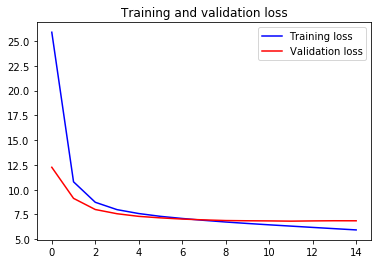

In [0]:
# Evaluation
import matplotlib.pyplot as plt
X_test_padded = tokenizer.texts_to_sequences(X_test)
X_test_padded = pad_sequences(X_test_padded, maxlen=MAX_SEQUENCE_LENGTH)
score = model.evaluate(X_test_padded, y_test, batch_size=512)
print("LOSS:",score)

# loss = history['loss']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(loss))
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

In [0]:
# A wrapper function in order to predict the tags for any given input

def predict_tags(text):
    # Tokenize text
    x_test = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=MAX_SEQUENCE_LENGTH)
    # Predict
    prediction = model.predict([x_test])[0]
    for i,value in enumerate(prediction):
        if value > 0.5:
            prediction[i] = 1
        else:
            prediction[i] = 0
    tags = tag_encoder.inverse_transform(np.array([prediction]))
    return tags

In [0]:
test_idx = np.random.randint(len(X_test), size=5)

for idx in test_idx:
    test_case = idx
    print('Test Case: ' + str(X_test[test_case]))
    print('-'*100)
    print('Predicted: ' + str(predict_tags(X_test[test_case])))
    print('Ground Truth: ' + str(tag_encoder.inverse_transform(np.array([y_test[test_case]]))))
    print('\n')

Test Case: pdf parser written objective c c
----------------------------------------------------------------------------------------------------
Predicted: [('ios', 'iphone', 'objective-c')]
Ground Truth: [('c', 'iphone', 'objective-c', 'pdf')]


Test Case: collapsing padded div vs padded fieldset
----------------------------------------------------------------------------------------------------
Predicted: [('css', 'html', 'javascript')]
Ground Truth: [('css', 'html')]


Test Case: suggestions changing function map expression
----------------------------------------------------------------------------------------------------
Predicted: [('javascript',)]
Ground Truth: [('function', 'numpy', 'python')]


Test Case: change backround image another div hovering list item
----------------------------------------------------------------------------------------------------
Predicted: [('css', 'html')]
Ground Truth: [('css', 'javascript')]


Test Case: produce php function call wordpress
-----